# check_matched_props
Plot the properties of CosmoDC2 galaxies that have been matched to GHOST galaxies.

import numpy as np
import GCRCatalogs
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from scipy import stats
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import pandas as pd
import os
import glob
import seaborn as sns
from astropy import table
from collections import OrderedDict as odict
import matplotlib
matplotlib.rcParams['text.usetex'] = False
## check version
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from astropy import table
import seaborn as sns
import os

In [8]:
def collect_snana_outputs(path): #path may be single or list
    if type(path)==str:
        headfiles = sorted(glob.glob(path+ '*HEAD.FITS.gz'))
        photfiles = sorted(glob.glob(path+ '*PHOT.FITS.gz'))
    elif type(path)==list:
        headfiles = []
        photfiles = []
        for p in path:
            headfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS.gz')))
            photfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS.gz')))
            
    c=0
    for file in headfiles:
        if c==0:
            headfile = table.Table.read(file, format='fits').to_pandas()
        else:
            headfile=headfile.append(table.Table.read(file, format='fits').to_pandas())
        c+=1
    # phots = []
    # for file in photfiles:
    #     photfile = table.Table.read(file, format='fits').to_pandas()
    #     phots.append(photfile)
    #     print(len(photfile))
    # concat_phots = pd.concat(phots)
    return headfile

def snhost_props(cat):
    G = cat['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
    R = cat['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
    I = cat['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
    Z = cat['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
    ellip  = cat['HOSTGAL_ELLIPTICITY']
    rshift = cat['REDSHIFT_FINAL']
    gr = G-R
    iz = I-Z
    logmass = cat['SIM_HOSTLIB(LOGMASS_TRUE)']
    sfr = cat['SIM_HOSTLIB(LOG_SFR)']
    return(G,R,I,Z,ellip,rshift,gr,iz,logmass,sfr)

In [9]:
# mode = 'SN Ia'
# mode = 'SN II'
mode = 'SN Ibc'

if ' ' in mode:
    modestr = mode.replace(' ','')

In [10]:
hostlibs_path = '/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/ELASTICC/HOSTLIB/'
annoy_path = '/global/cscratch1/sd/mlokken/sn_hostenv/matchedSamples_1218/'
snana_path = '/global/cscratch1/sd/kessler/SNANA_LSST_SIM/'
#GP_ELAsTiCC_Validation/

In [11]:
ls /global/cscratch1/sd/agaglian/cdc2_matched_fullSamples/

cdc2_matched_ghost_SNII_unq_zwgt_5pct_k2081_wIxx.tar.gz*
cdc2_matched_ghost_SNIa_unq_zwgt_5pct_k815_wIxx.tar.gz*
cdc2_matched_ghost_SNIbc_unq_zwgt_5pct_k17804_wIxx.tar.gz*
rand_hostlib_wIxx.tar.gz*


In [12]:
ls /global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/ELASTICC/HOSTLIB

AAA_README              SNIb_GHOST.WGTMAP.gz
AGN_GHOST.WGTMAP.gz     SNIbc_GHOST.HOSTLIB.gz
KN_GHOST.WGTMAP.gz      SNIcBL_GHOST.WGTMAP.gz
SLSNI_GHOST.WGTMAP.gz   SNIc_GHOST.WGTMAP.gz
SN91bg_GHOST.WGTMAP.gz  TDE_GHOST.WGTMAP.gz
SNII_GHOST.HOSTLIB.gz   UNMATCHED_COSMODC2_GHOST.HOSTLIB.gz
SNII_GHOST.WGTMAP.gz    UNMATCHED_KN_SHIFT_GHOST.HOSTLIB.gz
SNIa_GHOST.HOSTLIB.gz   archive/
SNIa_GHOST.WGTMAP.gz    v0_SciBook2009/
SNIax_GHOST.WGTMAP.gz


In [29]:
hostlib     = pd.read_csv(hostlibs_path+"{:s}_GHOST.HOSTLIB.gz".format(mode.replace(" ", '')), sep=' ', header=16)
col_hostlib = hostlib.columns.to_list()

In [30]:
hostlib

,VARNAMES:,GALID,RA_GAL,DEC_GAL,ZTRUE,ZPHOT,ZPHOT_ERR,u_obs,u_obs_err,g_obs,...,b1_Sersic,n1_Sersic,w1_Sersic,a_rot,ELLIPTICITY,LOGMASS,LOG_SFR,OBJID2,Unnamed: 33,NBR_LIST
0,GAL:,10938869183,50.622897,-44.629667,0.975561,0.975561,0.01,23.874016,0.062752,23.586435,...,0.267582,4,0.960352,73.656614,0.053410,10.270175,-0.056121,-999.0,NaN,2088572
1,GAL:,11564005688,50.442544,-44.639395,0.783607,0.783607,0.01,27.434507,3.145046,26.239788,...,0.108148,4,0.818881,52.339451,0.170850,9.633319,-2.326582,-999.0,NaN,-1
2,GAL:,11563034476,50.444670,-44.635095,0.734847,0.734847,0.01,25.155554,0.239154,24.568216,...,0.161168,4,0.000000,94.300582,0.006375,8.866477,-0.908408,-999.0,NaN,-1
3,GAL:,11564459807,50.442724,-44.629463,0.842456,0.842456,0.01,26.992200,0.649213,25.282946,...,0.328499,4,1.000000,128.295414,0.060451,10.854205,-2.537858,-999.0,NaN,-1
4,GAL:,11563499072,50.483955,-44.628496,0.406069,0.406069,0.01,23.467512,0.042774,22.886770,...,0.640625,4,1.000000,125.959353,0.015433,11.151119,-0.347141,-999.0,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681230,GAL:,12064898961,73.725048,-46.069885,0.958185,0.958185,0.01,26.438482,0.438154,26.513500,...,0.035346,4,0.999471,96.126801,0.141140,6.441611,-4.648201,-999.0,NaN,-1
2681231,GAL:,12064899032,73.835894,-44.513168,0.912747,0.912747,0.01,26.974699,0.827786,27.117281,...,0.037272,4,0.000000,108.125673,0.019724,6.914020,-3.976711,-999.0,NaN,-1
2681232,GAL:,12064899065,73.241192,-44.899862,0.960125,0.960125,0.01,26.099483,0.393141,26.203737,...,0.073364,4,0.998781,88.290979,0.169205,6.304829,-4.353181,-999.0,NaN,2664722
2681233,GAL:,12064899287,73.269478,-45.274110,0.925092,0.925092,0.01,27.351112,1.937731,27.477062,...,0.036073,4,0.000000,15.334126,0.116765,7.190786,-1.079794,-999.0,NaN,2643707


In [15]:
for file in os.listdir(annoy_path):
    if mode.replace(" ", "") in file:
        print(file)
        annoy_cat = pd.read_csv(annoy_path+file)
        col_annoy = annoy_cat.columns.to_list()

cdc2_matched_ghost_SNIbc_z3_unq_zwgt_5pct_k19017.tar.gz
cdc2_matched_ghost_SNIbc_z3_unq_zwgt_5pct_k9508_SFRMsol.tar.gz


In [34]:
randh = np.random.choice(np.arange(len(hostlib['ELLIPTICITY'])), replace=False, size=10000)
hg = hostlib['g_obs'].iloc[randh]
h_ellip = hostlib['ELLIPTICITY'].iloc[randh]
h_rshift = hostlib['ZTRUE'].iloc[randh]
h_gr = hostlib['g_obs'].iloc[randh]-hostlib['r_obs'].iloc[randh]
h_ri = hostlib['r_obs'].iloc[randh]-hostlib['i_obs'].iloc[randh]
h_iz = hostlib['i_obs'].iloc[randh]-hostlib['z_obs'].iloc[randh]

In [16]:
rand = np.random.choice(np.arange(len(annoy_cat['ra'])), replace=False, size=10000)
aG = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]
a_rshift = annoy_cat['DC2redshift'].iloc[rand]
a_gr = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]
a_ri = annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]
a_iz = annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_z_sdss_z0'].iloc[rand]
dist = annoy_cat['nn_distance'].iloc[rand]


In [18]:
resampled = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2full_pzRedshifts_31Healpix_sdss_updMag_Rkpc_Final.tar.gz")
rand = np.random.choice(np.arange(len(resampled['PZflowredshift'])), replace=False, size=10000)
cG = resampled['Mag_true_g_sdss_z0'].iloc[rand]
cR = resampled['Mag_true_r_sdss_z0'].iloc[rand]
cI = resampled['Mag_true_i_sdss_z0'].iloc[rand]
cZ = resampled['Mag_true_z_sdss_z0'].iloc[rand]
c_rshift = resampled['PZflowredshift'].iloc[rand]
c_gr = cG-cR
c_iz = cI-cZ
c_ri = cR-cI

In [17]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/GP_ELAsTiCC_Validation/


MLAG_GP_zALL_MODEL15_TDE_FULL/
MLAG_GP_zALL_MODEL42_V19_CC+HostXT_FULL/
MLAG_GP_zALL_MODEL42_V19_SNII+HostXT_FULL/
MLAG_GP_zALL_MODEL52_SNIax_FULL/
MLAG_GP_zALL_MODEL67_SNIa-91bg_FULL/
MLAG_GP_zALL_MODEL811_SNIb_FULL/
MLAG_GP_zALL_MODEL812_SNIc_FULL/
MLAG_GP_zALL_MODEL812_SNIc_FULL_EXAGG/
MLAG_GP_zALL_MODEL813_SNIcBL_FULL/
MLAG_GP_zALL_MODEL813_SNIcBL_FULL_EXAGG/
MLAG_GP_zALL_MODEL90_SNIa-SALT2_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_NOWGT_RANDHOST/
MLAG_GP_zALL_MODEL95_SLSN-I_WGT_RANDHOST/
kilonovae/
kilonovae.tar.gz
newRuns.tar.gz


In [39]:
if mode=='SN Ia':
    model_list = [snana_path + 'MLAG_IDEAL_zALL_MODEL90_SNIa-SALT2_FULL/']
    snana_model_path = snana_path + 'MLAG_IDEAL_zALL_MODEL90_SNIa-SALT2_FULL/'
    modelname_list = ['SNIa']
    outputs = collect_snana_outputs(snana_model_path)
if mode=='SN II':
    model_list = []
if mode=='SN Ibc':
    # model_list = ['MLAG_IDEAL_zALL_MODEL811_SNIb_FULL/', 'MLAG_IDEAL_zALL_MODEL812_SNIc_FULL/', 'MLAG_IDEAL_zALL_MODEL95_SLSN-I_FULL/']
    # modelname_list = ['SNIb', 'SNIc', 'SLSN-I']
    model_list = ['MLAG_GP_zALL_MODEL812_SNIcMetalCorr/', 'MLAG_GP_zALL_MODEL813_SNIcBLMetalCorr/',]
    modelname_list = ['SNIc', 'SNIc-BL']
    outputs = [] # a list of dataframes for each model
    for model in model_list:
        snana_model_path = snana_path+model
        print(snana_model_path)
        outputs.append(collect_snana_outputs(snana_model_path))
        
if type(outputs)==pd.DataFrame: # if only one DataFrame -- means there's only one model in this grouping
    print("SN Ia")
    output_cols = outputs.columns
    oG = outputs['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
    oR = outputs['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
    oI = outputs['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
    oZ = outputs['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
    o_ellip = outputs['HOSTGAL_ELLIPTICITY']
    o_rshift = outputs['REDSHIFT_FINAL']
    o_gr = oG-oR
    o_ri = oR-oI
    o_iz = oI-oZ
else:
    oG = [out['SIM_HOSTLIB(Mag_true_g_sdss_z0)'] for out in outputs]
    oR = [out['SIM_HOSTLIB(Mag_true_r_sdss_z0)'] for out in outputs]
    oI = [out['SIM_HOSTLIB(Mag_true_i_sdss_z0)'] for out in outputs]
    oZ = [out['SIM_HOSTLIB(Mag_true_z_sdss_z0)'] for out in outputs]
    o_ellip = [out['HOSTGAL_ELLIPTICITY'] for out in outputs]
    o_rshift = [out['REDSHIFT_FINAL'] for out in outputs]
    o_gr = [oG[i]-oR[i] for i in range(len(model_list))]
    o_ri = [oR[i]-oI[i] for i in range(len(model_list))]
    o_iz = [oI[i]-oZ[i] for i in range(len(model_list))]

/global/cscratch1/sd/kessler/SNANA_LSST_SIM/MLAG_GP_zALL_MODEL812_SNIcMetalCorr/
/global/cscratch1/sd/kessler/SNANA_LSST_SIM/MLAG_GP_zALL_MODEL813_SNIcBLMetalCorr/


In [20]:
# Import GHOST data
file = '../../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
# First group by transient class

if mode == 'SN II':
    a = ghost['TransientClass']==mode
    b = ghost['TransientClass']=='SN IIP'
    c = ghost['TransientClass']=='SN IIn'
    ghost = ghost[a|b|c]
elif mode == 'SN Ibc': # group all stripped-envelope supernovae
    a = ghost['TransientClass'] == 'SN Ib'
    b = ghost['TransientClass'] =='SN IIb'
    c = ghost['TransientClass'] == 'SN Ic'
    d = ghost['TransientClass'] == 'SLSN-I' # lump in SLSN hosts because there are too few of them for it to be its own hostlib
    ghost = ghost[a | b | c | d]
else:
    ghost = ghost[ghost['TransientClass']==mode]
ghost.reset_index(inplace=True)
print("Number of {:s}: {:d}".format(mode,len(ghost)))
transient_class = ghost['TransientClass']
gG = ghost['gKronMag_SDSS_abs']
gR = ghost['rKronMag_SDSS_abs']
gI = ghost['iKronMag_SDSS_abs']
gZ = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']


Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
Number of SN Ibc: 506


In [21]:
ghost_keys = [gG, g_gr, g_ri, g_iz, g_rshift]
cdc2_all   = [cG, c_gr, c_ri, c_iz, c_rshift]
# hostlib    = [hg, h_gr, h_ri, h_iz, h_ellip, h_rshift]
annoy      = [aG, a_gr, a_ri, a_iz, a_rshift]
# snana      = [oG, o_gr, o_ri, o_iz, o_ellip, o_rshift]
# snana = np.asarray(snana)

# broadline  = [oG_bl, o_gr_bl, o_iz_bl, o_ellip_bl, o_rshift_bl]

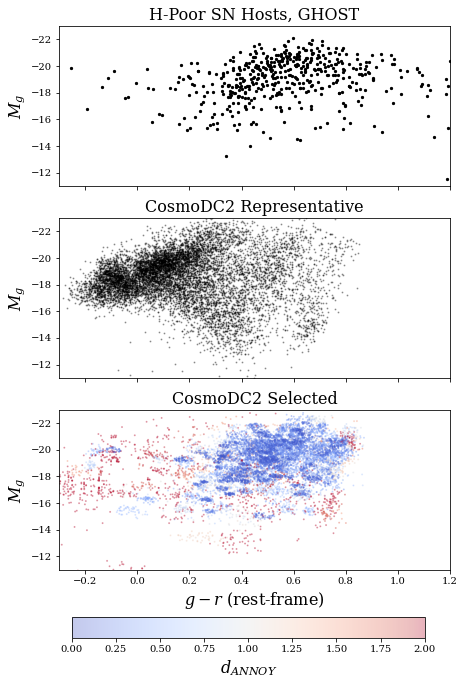

<Figure size 432x288 with 0 Axes>

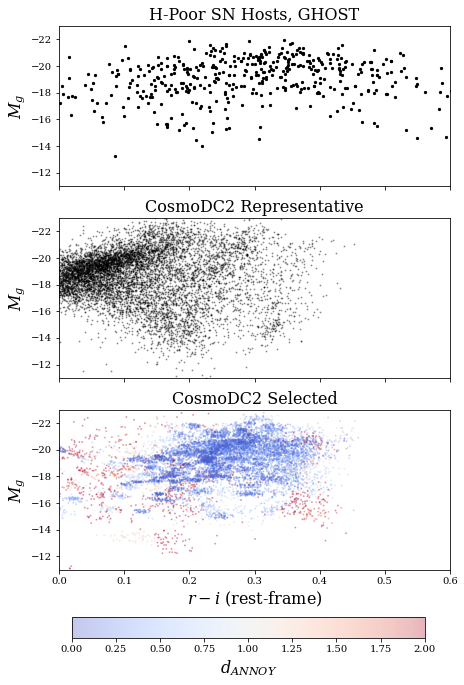

<Figure size 432x288 with 0 Axes>

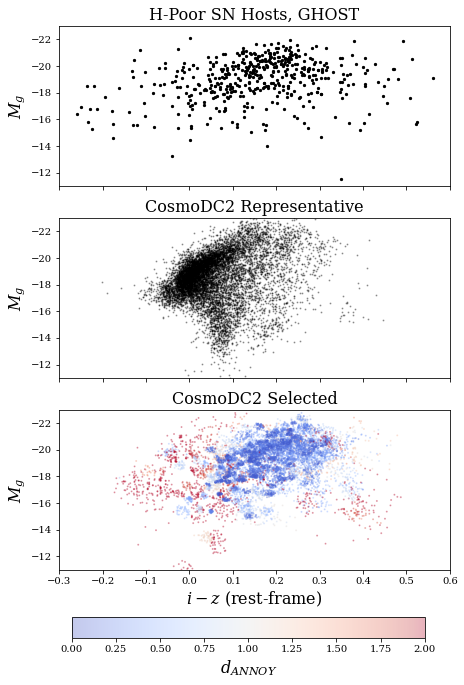

<Figure size 432x288 with 0 Axes>

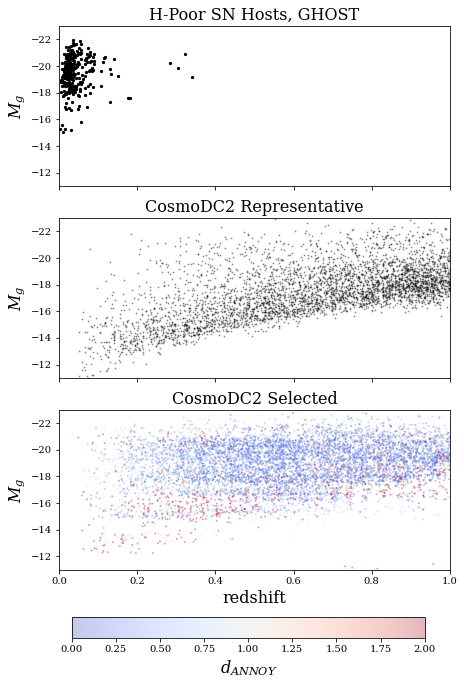

<Figure size 432x288 with 0 Axes>

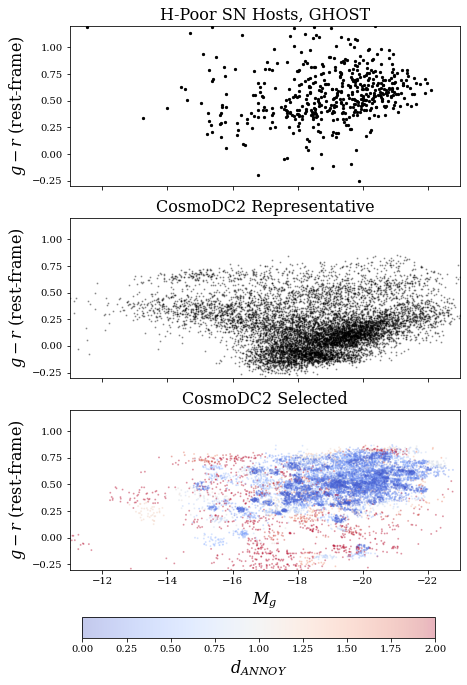

<Figure size 432x288 with 0 Axes>

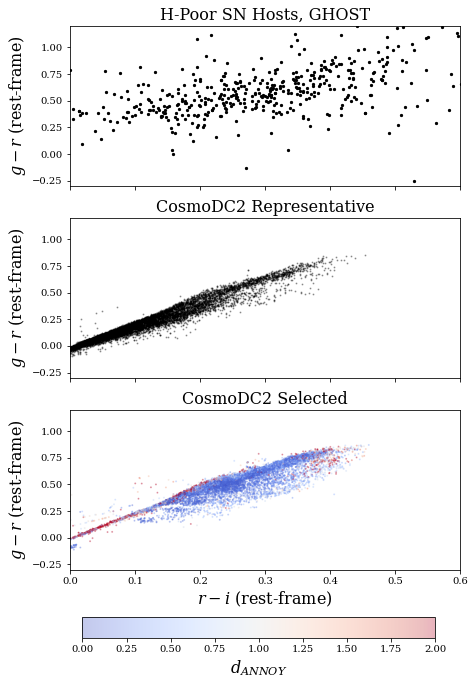

<Figure size 432x288 with 0 Axes>

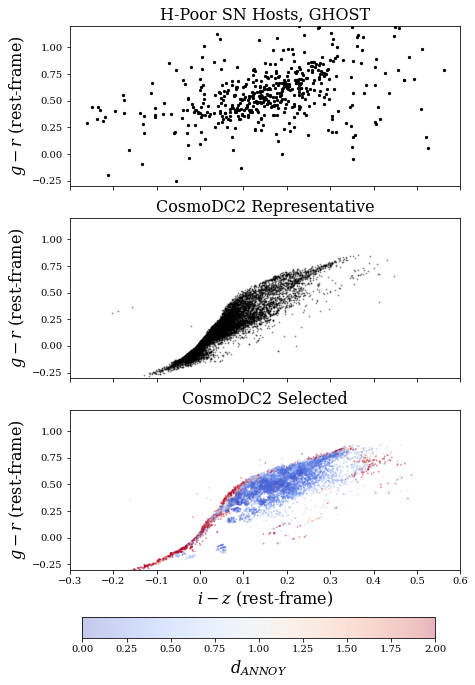

<Figure size 432x288 with 0 Axes>

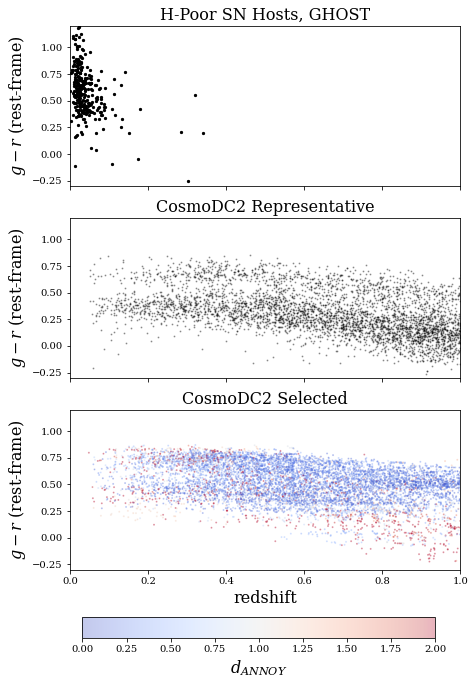

<Figure size 432x288 with 0 Axes>

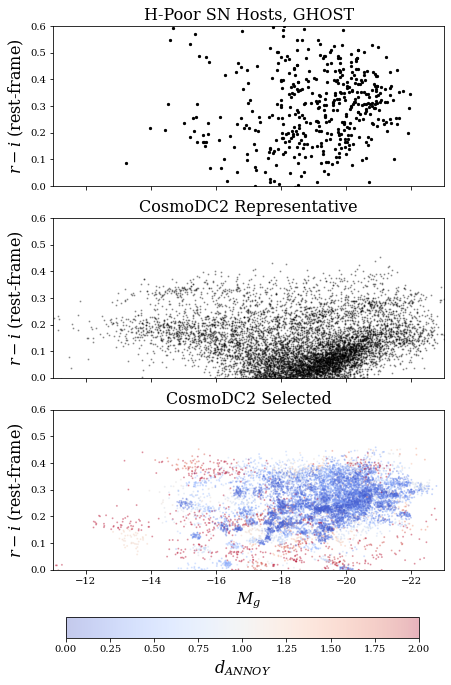

<Figure size 432x288 with 0 Axes>

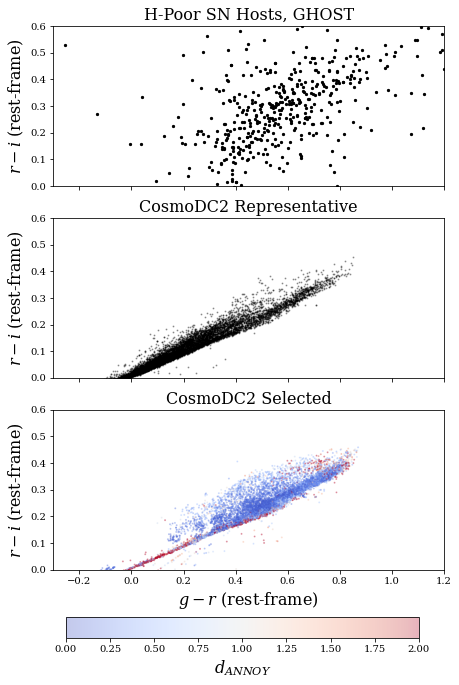

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

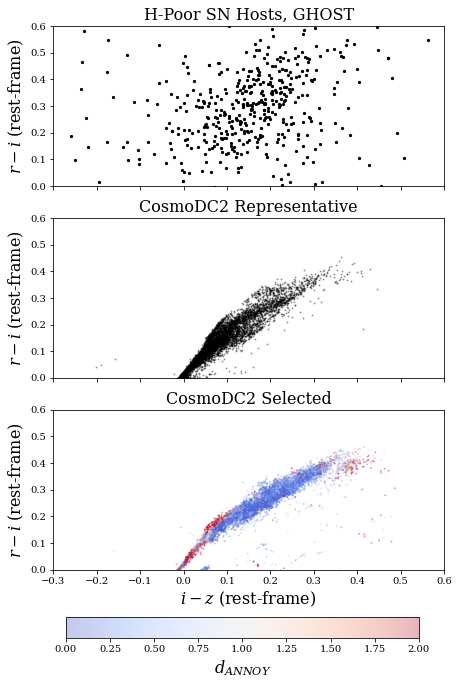

In [25]:
# 2D scatter plots
plt.rcParams.update({'font.family':'serif'})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plot_hostlib = False
plot_snana   = False
# check all properties against each other for CosmoDC2
labels=[r'$M_g$', '$g-r$ (rest-frame)', '$r-i$ (rest-frame)', '$i-z$ (rest-frame)', 'redshift']
lims =[[-11,-23],[-0.3,1.2],[0,0.6],[-0.3,0.6],[0,1]]
for i in range(5):
    for j in range(5):
        if i!=j:
            nrows=3
            figsize=[7,10]
            fig,ax = plt.subplots(nrows=nrows,ncols=1,figsize=figsize,sharex=True)
            im1=ax[0].scatter(ghost_keys[j],ghost_keys[i], s=5, c='k')
            ax[0].set_title("H-Poor SN Hosts, GHOST", fontsize=16)
            if not plot_snana:
                im2=ax[1].scatter(cdc2_all[j],cdc2_all[i], alpha=0.3, s=1, c='k')
                ax[1].set_title("CosmoDC2 Representative", fontsize=16)
            if plot_hostlib:
                im3=ax[2].scatter(hostlib[j],hostlib[i], alpha=0.3, s=1)
            else:
                if plot_snana:
                    axnum = 1
                else:
                    axnum = 2
                if plot_snana:
                    # don't plot ANNOY distances
                    im3=ax[axnum].scatter(annoy[j],annoy[i], alpha=0.3, s=1, c='k')
                else:
                    im3=ax[axnum].scatter(annoy[j],annoy[i], alpha=0.3, s=1, c=dist, vmin=0, vmax=2, cmap='coolwarm')
            if plot_snana:
                # im4 = ax[3].scatter(snana[j], snana[i], alpha=0.3, s=1, c='tab:blue')
                for m in range(len(model_list)):
                    if len(model_list)>1:
                    # for 3-plot with SLSN, Ib, Ic
                        ax[2].scatter(snana[j,m], snana[i,m], label=modelname_list[m], color=['#66c2a5', '#fc8d62', '#c26683'][m], s=2)
                    # for 2-plot with Ic, Ic-BL
                    #ax[2].scatter(snana[j,m], snana[i,m], label=modelname_list[m], color=['#66c2a5', '#fc8d62'][m], s=2)
                        ax[2].legend(fontsize=16)
                    else:
                        ax[2].scatter(snana[j], snana[i], alpha=0.3, s=1, c='tab:blue')
                # ax[3].scatter(broadline[j], broadline[i], alpha=0.3, s=1, c='tab:orange')
            ax[nrows-1].set_xlabel(labels[j], fontsize=16)
            if not plot_snana:
                cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.03])
                cb = fig.colorbar(im3, cax=cbar_ax, orientation='horizontal')
                cb.set_label(label='$d_{ANNOY}$',fontsize=16)
            for m in range(nrows):
                ax[m].set_ylabel(labels[i], fontsize=16)

            if not plot_snana:
                ax[2].set_title("CosmoDC2 Selected", fontsize=16)
            else:
                ax[1].set_title("CosmoDC2 Selected", fontsize=16)
                ax[2].set_title("SNANA Selected", fontsize=16)
            for m in range(nrows):
                ax[m].set_xlim(lims[j])
                ax[m].set_ylim(lims[i])
            
            plt.savefig("../plots/ghost_cdc2_annoy_{:s}_vs_{:s}_{:s}.png".format(labels[i].replace("$",""),labels[j].replace("$",""),mode.replace(' ','')), bbox_inches='tight')
            plt.show()
            plt.clf()



In [26]:
pwd

'/global/u2/m/mlokken/transient-host-sims/notebooks/validation_notebooks'

(array([  9770.,  64219., 170010., 272577., 415999., 571585., 561386.,
        448610., 162997.,   5818.]),
 array([ 5.05940629,  5.76149675,  6.4635872 ,  7.16567765,  7.86776811,
         8.56985856,  9.27194901,  9.97403946, 10.67612992, 11.37822037,
        12.08031082]),
 <a list of 10 Patch objects>)

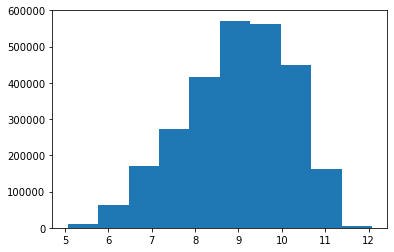

In [44]:
plt.hist(np.log10(annoy_cat['stellar_mass']))

In [ ]:
annoy_col

In [ ]:
plt.hist(

/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


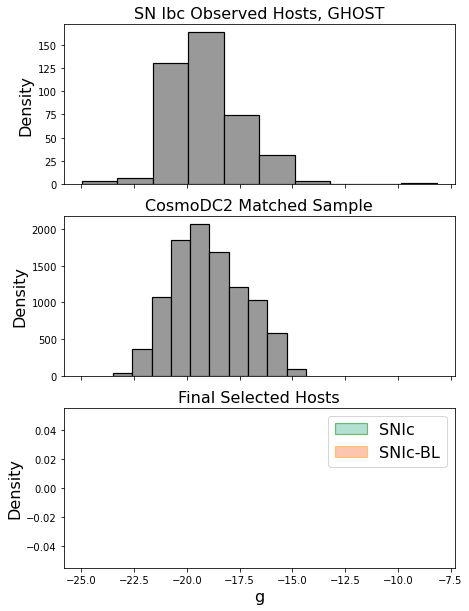

<Figure size 432x288 with 0 Axes>

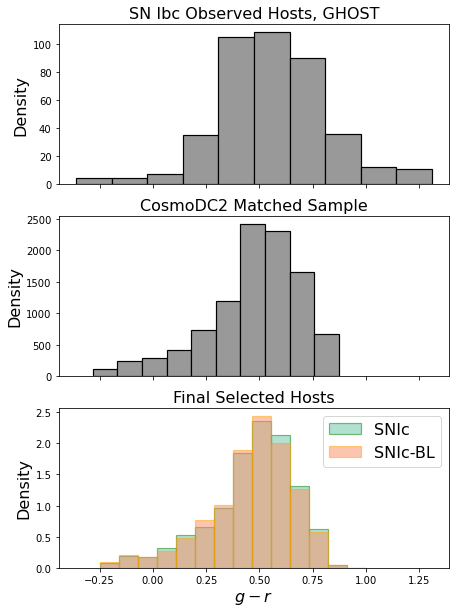

<Figure size 432x288 with 0 Axes>

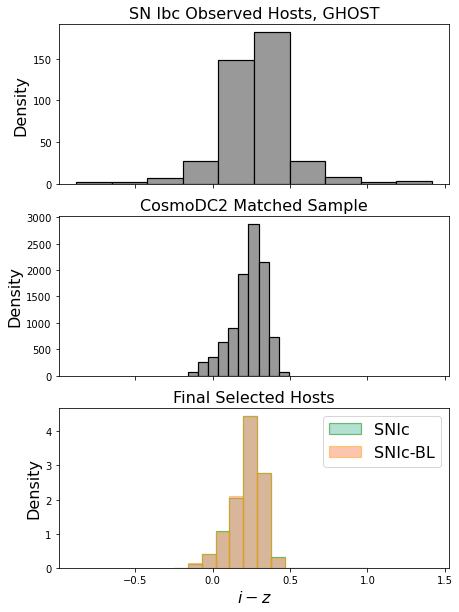

<Figure size 432x288 with 0 Axes>

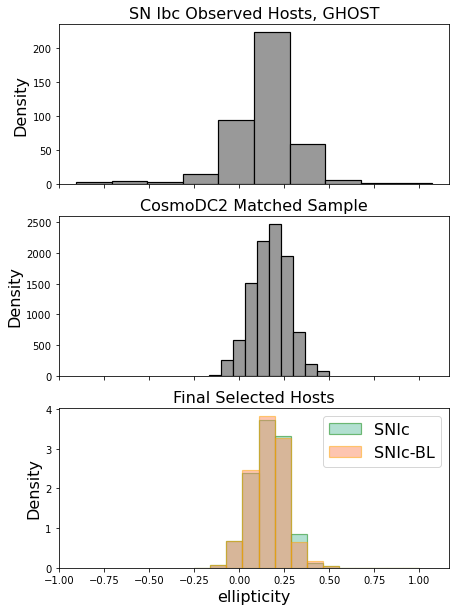

<Figure size 432x288 with 0 Axes>

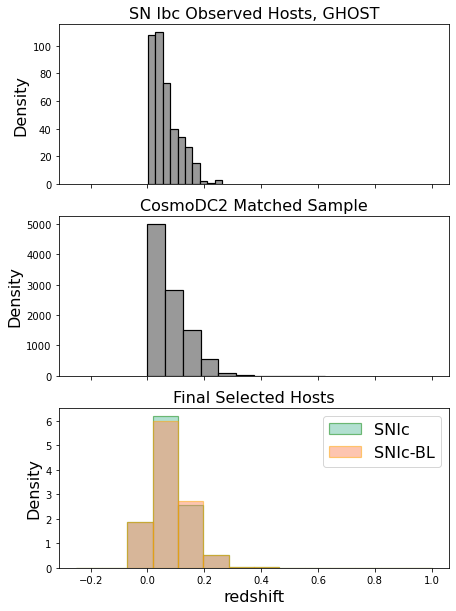

<Figure size 432x288 with 0 Axes>

In [21]:
#1D Hists
plot_hostlib = False
plot_snana   = True
# check all properties against each other for CosmoDC2
labels=['g', r'$g-r$', r'$i-z$', 'ellipticity', 'redshift']
lims =[[-25,-14.5],[-0.3,1.2],[-0.3,0.6],[0,0.4],[0,1]]
for i in range(5):
    nrows=3
    figsize=[7,10]
    fig,ax = plt.subplots(nrows=nrows,ncols=1,figsize=figsize,sharex=True)
    im1=ax[0].hist(ghost_keys[i],color='0.6', histtype='bar', linewidth=1.2, edgecolor='black')
    ax[0].set_title("{:s} Observed Hosts, GHOST".format(mode), fontsize=16)
    if plot_hostlib:
        im3=ax[2].hist(hostlib[i])
    else:
        axnum = 1
        im3=ax[axnum].hist(annoy[i], color='0.6', histtype='bar', linewidth=1.2, edgecolor='black')
    if plot_snana:
        # im4 = ax[3].scatter(snana[j], snana[i], alpha=0.3, s=1, c='tab:blue')
        for m in range(len(model_list)):
            if len(model_list)>1:
                ax[2].hist(snana[i,m], label=modelname_list[m], color=['#66c2a5', '#fc8d62', '#8da0cb'][m], alpha=.5, histtype='bar', bins=np.linspace(-.25,1,15), linewidth=1.2, edgecolor=['green','orange', 'blue'][m], density=True)
                ax[2].legend(fontsize=16)
            #'#201335', 
            else:
                ax[2].scatter(snana[j], snana[i], alpha=0.3, s=1, c='tab:blue')
        # ax[3].scatter(broadline[j], broadline[i], alpha=0.3, s=1, c='tab:orange')
    ax[nrows-1].set_xlabel(labels[i], fontsize=16)
    if not plot_snana:
        cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.03])
        cb = fig.colorbar(im3, cax=cbar_ax, orientation='horizontal')
        cb.set_label(label='$d_{ANNOY}$',fontsize=16)
    for m in range(nrows):
        ax[m].set_ylabel('Density', fontsize=16)

    if not plot_snana:
        ax[2].set_title("CosmoDC2 Matched Sample", fontsize=16)
    else:
        ax[1].set_title("CosmoDC2 Matched Sample", fontsize=16)
        ax[2].set_title("Final Selected Hosts", fontsize=16)

    # plt.savefig("plots/ghost_annoy_SNANA_hist_{:s}_{:s}.png".format(labels[i],mode.replace(' ','')), bbox_inches='tight')
    plt.show()
    plt.clf()


# Validation: SLSN-I

## 1) Random hostlib, no weightmap.

In [54]:
# Import GHOST data
mode = 'SN Ia'

# Import GHOST data
file = '../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
# First group by transient class
if mode == 'SN II':
    a = ghost['TransientClass']==mode
    b = ghost['TransientClass']=='SN IIP'
    c = ghost['TransientClass']=='SN IIb'
    d = ghost['TransientClass']=='SN IIn'
    ghost = ghost[np.logical_or(np.logical_or(np.logical_or(a,b),c), d)]
elif mode == 'SN Ibc':
    a = ghost['TransientClass'] == 'SN Ib'
    b = ghost['TransientClass'] == 'SN Ic'
    c = ghost['TransientClass'] == 'SLSN-I' # lump in SLSN hosts because there are too few of them for it to be its own hostlib
    ghost = ghost[np.logical_or(np.logical_or(a,b),c)]
else:
    ghost = ghost[ghost['TransientClass'] == mode]
ghost.reset_index(inplace=True)
print("Number of {:s}: {:d}".format(mode,len(ghost)))
transient_class = ghost['TransientClass']
gG = ghost['gKronMag_SDSS_abs']
gR = ghost['rKronMag_SDSS_abs']
gI = ghost['iKronMag_SDSS_abs']
gZ = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']


Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
Number of SN Ia: 8390


In [55]:
gp_path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GP_ELAsTiCC_Validation/"
hosts_randlib_nowgt = collect_snana_outputs(gp_path+"MLAG_GP_zALL_MODEL95_SLSN-I_NOWGT_RANDHOST/")
hosts_randlib_wgt   = collect_snana_outputs(gp_path+"MLAG_GP_zALL_MODEL95_SLSN-I_WGT_RANDHOST/")
hosts_hostlib_wgt   = collect_snana_outputs(gp_path+"MLAG_GP_zALL_MODEL95_SLSN-I_FULL/")

KeyboardInterrupt: 

In [56]:
annoy_path = '/global/cscratch1/sd/agaglian/cdc2_matched_fullSamples/'
for file in os.listdir(annoy_path):
    if mode.replace(" ", "") in file:
        print(file)
        annoy_cat = pd.read_csv(annoy_path+file)
        col_annoy = annoy_cat.columns.to_list()

cdc2_matched_ghost_SNIa_unq_zwgt_5pct_k815_wIxx.tar.gz


In [57]:
rand = np.random.choice(np.arange(len(annoy_cat['ra'])), replace=False, size=10000)
aG = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]
a_ellip = annoy_cat['totalEllipticity'].iloc[rand]
a_rshift = annoy_cat['DC2redshift'].iloc[rand]
a_gr = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]
a_ri = annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]
a_iz = annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_z_sdss_z0'].iloc[rand]
dist = annoy_cat['nn_distance'].iloc[rand]
a_logmass = np.log10(annoy_cat['stellar_mass']).iloc[rand]
a_sfr = np.log10(annoy_cat['SFRtot']).iloc[rand]

In [59]:
mode

'SN Ia'

(array([  10.,   33.,   88.,  484., 1083., 1557., 1620., 1954., 2281.,
         890.]),
 array([1.05431795, 1.94872317, 2.84312839, 3.73753361, 4.63193883,
        5.52634406, 6.42074928, 7.3151545 , 8.20955972, 9.10396494,
        9.99837017]),
 <a list of 10 Patch objects>)

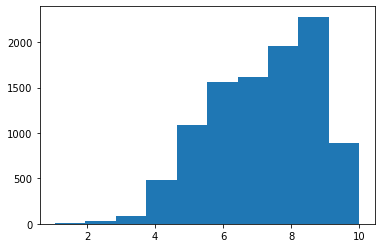

In [58]:
plt.hist(a_sfr)

In [ ]:
plt.hist(a_logmass)

In [10]:
G_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
R_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
I_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
Z_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
ellip_rnw = hosts_randlib_nowgt['HOSTGAL_ELLIPTICITY']
rshift_rnw = hosts_randlib_nowgt['REDSHIFT_FINAL']
gr_rnw = G_rnw-R_rnw
iz_rnw = I_rnw-Z_rnw
logmass_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(LOGMASS_TRUE)']
sfr_rnw = hosts_randlib_nowgt['SIM_HOSTLIB(LOG_SFR)']

G_rw = hosts_randlib_wgt['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
R_rw = hosts_randlib_wgt['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
I_rw = hosts_randlib_wgt['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
Z_rw = hosts_randlib_wgt['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
logmass_rw = hosts_randlib_wgt['SIM_HOSTLIB(LOGMASS_TRUE)']
sfr_rw = hosts_randlib_wgt['SIM_HOSTLIB(LOG_SFR)']
ellip_rw = hosts_randlib_wgt['HOSTGAL_ELLIPTICITY']
rshift_rw = hosts_randlib_wgt['REDSHIFT_FINAL']
gr_rw = G_rw-R_rw
iz_rw = I_rw-Z_rw

G_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
R_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
I_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
Z_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
logmass_hw = hosts_hostlib_wgt['SIM_HOSTLIB(LOGMASS_TRUE)']
sfr_hw = hosts_hostlib_wgt['SIM_HOSTLIB(LOG_SFR)']
ellip_hw = hosts_hostlib_wgt['HOSTGAL_ELLIPTICITY']
rshift_hw = hosts_hostlib_wgt['REDSHIFT_FINAL']
gr_hw = G_hw-R_hw
iz_hw = I_hw-Z_hw

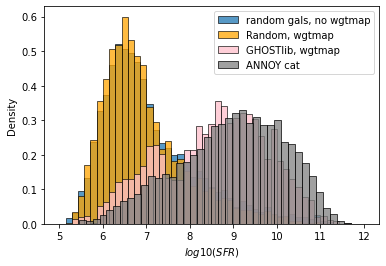

In [11]:
bins = np.linspace(5,12)
sns.histplot(logmass_rnw, stat='density', label='random gals, no wgtmap', bins=bins)
sns.histplot(logmass_rw, stat='density', bins=bins, label='Random, wgtmap', color='orange')
sns.histplot(logmass_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(a_logmass, stat='density', label='ANNOY cat', color='gray')
# sns.histplot(gR, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$log10(SFR)$")
plt.legend()

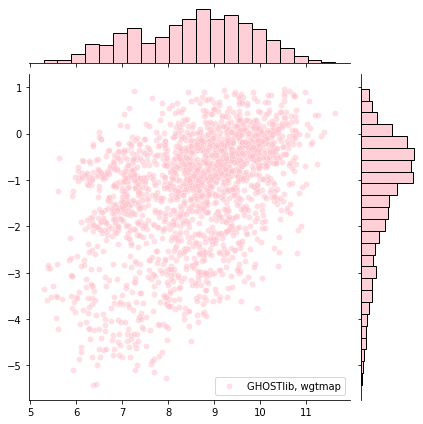

In [12]:

sns.jointplot(x=logmass_hw.to_numpy(), y=sfr_hw.to_numpy(), label='GHOSTlib, wgtmap', color='pink', alpha=.5)



/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


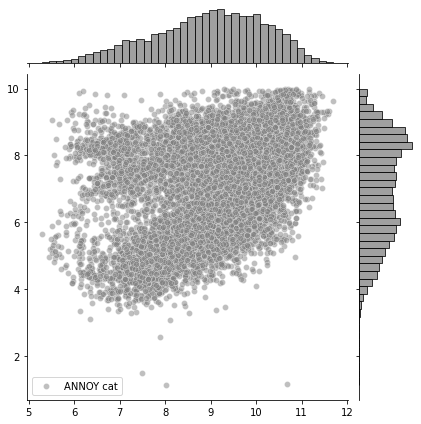

In [13]:
sns.jointplot(a_logmass.to_numpy(), a_sfr.to_numpy(),label='ANNOY cat', color='gray', alpha=.5)

/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


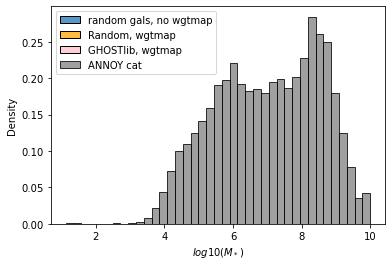

In [14]:
bins = np.linspace(5,12)
sns.histplot(sfr_rnw, stat='density', label='random gals, no wgtmap', bins=bins)
sns.histplot(sfr_rw, stat='density', bins=bins, label='Random, wgtmap', color='orange')
sns.histplot(sfr_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(a_sfr, stat='density', label='ANNOY cat', color='gray')
# sns.histplot(gR, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$log10(M_*)$")
plt.legend()

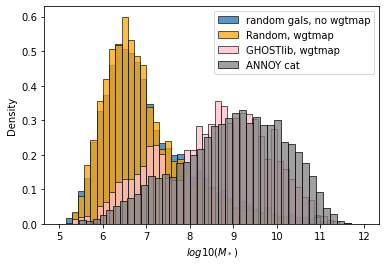

In [15]:
bins = np.linspace(5,12)
sns.histplot(logmass_rnw, stat='density', label='random gals, no wgtmap', bins=bins)
sns.histplot(logmass_rw, stat='density', bins=bins, label='Random, wgtmap', color='orange')
sns.histplot(logmass_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(a_logmass, stat='density', label='ANNOY cat', color='gray')
# sns.histplot(gR, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$log10(M_*)$")
plt.legend()

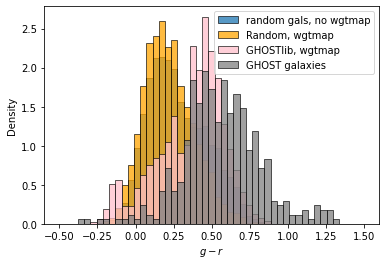

In [17]:
bins = np.linspace(-.5, 1.5)
sns.histplot(gr_rnw, stat='density', label='random gals, no wgtmap', bins=bins)
sns.histplot(gr_rw, stat='density', bins=bins, label='Random, wgtmap', color='orange')
sns.histplot(gr_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(g_gr, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$g-r$")
plt.legend()

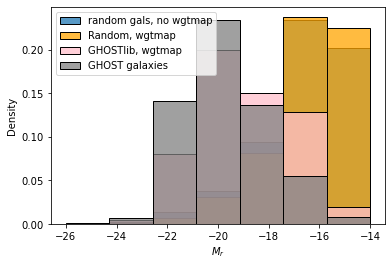

In [18]:
bins = np.linspace(-26,-14,8)
sns.histplot(R_rnw, stat='density', label='random gals, no wgtmap', bins=bins)
sns.histplot(R_rw, stat='density', bins=bins, label='Random, wgtmap', color='orange')
sns.histplot(R_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(gR, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$M_r$")
plt.legend()

# SN Ib

In [20]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/GP_ELAsTiCC_Validation/

MLAG_GP_zALL_MODEL15_TDE_FULL/
MLAG_GP_zALL_MODEL42_V19_CC+HostXT_FULL/
MLAG_GP_zALL_MODEL42_V19_SNII+HostXT_FULL/
MLAG_GP_zALL_MODEL52_SNIax_FULL/
MLAG_GP_zALL_MODEL67_SNIa-91bg_FULL/
MLAG_GP_zALL_MODEL811_SNIb_FULL/
MLAG_GP_zALL_MODEL812_SNIc_FULL/
MLAG_GP_zALL_MODEL812_SNIc_FULL_EXAGG/
MLAG_GP_zALL_MODEL813_SNIcBL_FULL/
MLAG_GP_zALL_MODEL813_SNIcBL_FULL_EXAGG/
MLAG_GP_zALL_MODEL90_SNIa-SALT2_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_NOWGT_RANDHOST/
MLAG_GP_zALL_MODEL95_SLSN-I_WGT_RANDHOST/
kilonovae/
kilonovae.tar.gz
newRuns.tar.gz


In [62]:
# hostlib
hostlib = pd.read_csv("/global/cfs/cdirs/snana/SURVEYS/LSST/ROOT/HOSTLIB/SNIbc_GHOST.HOSTLIB", sep=' ', header=15)

In [71]:
idx = np.random.choice(len(hostlib), replace=False, size=10000)
logm_h, sfr_h = hostlib['LOGMASS'][idx], hostlib['LOG_SFR'][idx]

In [22]:
hosts_hostlib_wgt   = collect_snana_outputs(gp_path+"MLAG_GP_zALL_MODEL811_SNIb_FULL/")


In [77]:
G,R,I,Z,ellip,rshift,gr,iz,logmass,sfr = snhost_props(hosts_hostlib_wgt)

In [36]:
hosts_hostlib_wgt['SIM_HOSTLIB(LOG_SFR)']

0    -0.265520
1    -2.264945
2    -4.546833
3    -4.213162
4    -4.601504
        ...   
80   -0.431824
81   -2.428293
82   -2.522497
83   -3.932137
84   -3.571309
Name: SIM_HOSTLIB(LOG_SFR), Length: 1808, dtype: float32

(array([3.000e+00, 1.000e+00, 5.700e+01, 6.520e+02, 1.275e+03, 1.763e+03,
        1.667e+03, 1.845e+03, 2.136e+03, 6.010e+02]),
 array([1.12756682, 2.01462111, 2.90167541, 3.78872971, 4.67578401,
        5.56283831, 6.4498926 , 7.3369469 , 8.2240012 , 9.1110555 ,
        9.9981098 ]),
 <a list of 10 Patch objects>)

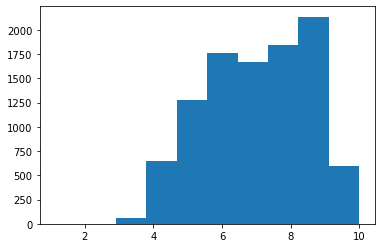

In [43]:
plt.hist(a_sfr)

In [94]:
wgt2 = pd.read_csv("/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/HOSTLIB/SNII_GHOST.WGTMAP.gz", sep='  ', header=11)

/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [84]:
wgt = pd.read_csv("/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/HOSTLIB/SNIb_GHOST.WGTMAP.gz", sep='  ', header=10)

/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


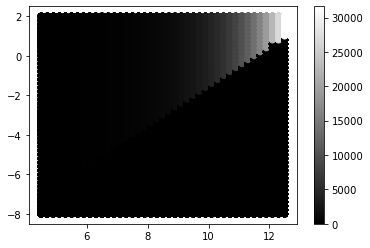

In [98]:
plt.scatter(wgt["LOGMASS"], wgt["LOG_SFR"], c=wgt["WGT"])
# plt.clim([0,100])
plt.gray()
plt.colorbar()

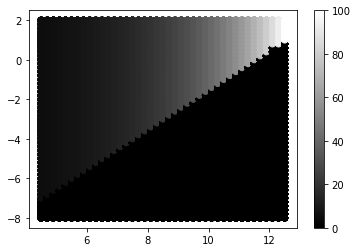

In [96]:
plt.scatter(wgt2["LOGMASS"], wgt2["LOG_SFR"], c=wgt2["WGT"])
plt.gray()
plt.colorbar()

(array([71604., 16575.,  6375.,  4182.,  2601.,  2142.,  1173.,   510.,
          816.,   663.]),
 array([0.00000000e+00, 8.65772684e-06, 1.73154537e-05, 2.59731805e-05,
        3.46309074e-05, 4.32886342e-05, 5.19463611e-05, 6.06040879e-05,
        6.92618147e-05, 7.79195416e-05, 8.65772684e-05]),
 <a list of 10 Patch objects>)

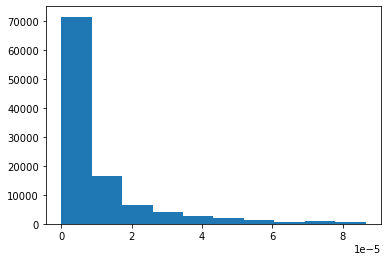

In [102]:
values2 = wgt2["WGT"]
plt.hist((values2 - values2.min()) / (values2 - values2.min()).sum())


(array([97767.,  3570.,  1479.,  1275.,   561.,   510.,   459.,   357.,
          357.,   306.]),
 array([0.00000000e+00, 2.63290303e-05, 5.26580606e-05, 7.89870909e-05,
        1.05316121e-04, 1.31645152e-04, 1.57974182e-04, 1.84303212e-04,
        2.10632242e-04, 2.36961273e-04, 2.63290303e-04]),
 <a list of 10 Patch objects>)

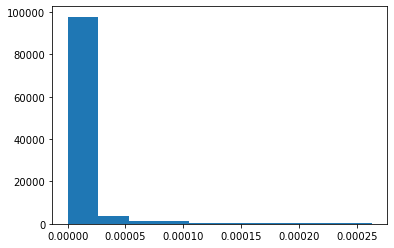

In [103]:
values = wgt["WGT"]
plt.hist((values - values.min()) / (values - values.min()).sum())


In [ ]:
values

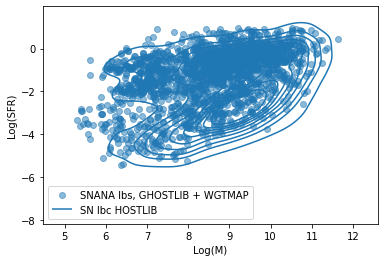

In [78]:
plt.scatter(logmass,sfr, label='SNANA Ibs, GHOSTLIB + WGTMAP', alpha=.5)
sns.kdeplot(x=logm_h, y=sfr_h, label='SN Ibc HOSTLIB')
plt.xlabel("Log(M)")
plt.ylabel("Log(SFR)")
plt.legend()

In [ ]:
# is the weightmap doing anything? Try same for SN II
mode = 'SN II'
# Import GHOST data
file = '../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
# First group by transient class
ghost = ghost[ghost['TransientClass'] == mode] # lump in SLSN hosts because there are too few of them for it to be its own hostlib

print("Number of SNII: {:d}".format(len(ghost)))
transient_class = ghost['TransientClass']
gG = ghost['gKronMag_SDSS_abs']
gR = ghost['rKronMag_SDSS_abs']
gI = ghost['iKronMag_SDSS_abs']
gZ = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']


Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
Number of SNII: 0


In [63]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/GP_ELAsTiCC_Validation/

MLAG_GP_zALL_MODEL15_TDE_FULL/
MLAG_GP_zALL_MODEL42_V19_CC+HostXT_FULL/
MLAG_GP_zALL_MODEL42_V19_SNII+HostXT_FULL/
MLAG_GP_zALL_MODEL52_SNIax_FULL/
MLAG_GP_zALL_MODEL67_SNIa-91bg_FULL/
MLAG_GP_zALL_MODEL811_SNIb_FULL/
MLAG_GP_zALL_MODEL812_SNIc_FULL/
MLAG_GP_zALL_MODEL813_SNIcBL_FULL/
MLAG_GP_zALL_MODEL90_SNIa-SALT2_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_FULL/
MLAG_GP_zALL_MODEL95_SLSN-I_NOWGT_RANDHOST/
MLAG_GP_zALL_MODEL95_SLSN-I_WGT_RANDHOST/
kilonovae/
kilonovae.tar.gz
newRuns.tar.gz


In [71]:
hosts_hostlib_wgt   = collect_snana_outputs(gp_path+"MLAG_GP_zALL_MODEL42_V19_SNII+HostXT_FULL/")

In [86]:
G_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_g_sdss_z0)']
R_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_r_sdss_z0)']
I_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_i_sdss_z0)']
Z_hw = hosts_hostlib_wgt['SIM_HOSTLIB(Mag_true_z_sdss_z0)']
logmass_hw = hosts_hostlib_wgt['SIM_HOSTLIB(LOGMASS_TRUE)']
ellip_hw = hosts_hostlib_wgt['HOSTGAL_ELLIPTICITY']
rshift_hw = hosts_hostlib_wgt['REDSHIFT_FINAL']
gr_hw = G_hw-R_hw
iz_hw = I_hw-Z_hw
sfr_hw = hosts_hostlib_wgt['SIM_HOSTLIB(LOG_SFR)']

In [76]:

annoy_path = '/global/cscratch1/sd/agaglian/cdc2_matched_fullSamples/'
for file in os.listdir(annoy_path):
    if mode.replace(" ", "") in file:
        print(file)
        annoy_cat = pd.read_csv(annoy_path+file)
        col_annoy = annoy_cat.columns.to_list()

cdc2_matched_ghost_SNII_unq_zwgt_5pct_k2081_wIxx.tar.gz


In [106]:
rand = np.random.choice(np.arange(len(annoy_cat['ra'])), replace=False, size=10000)
aG = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]
a_ellip = annoy_cat['totalEllipticity'].iloc[rand]
a_rshift = annoy_cat['DC2redshift'].iloc[rand]
a_gr = annoy_cat['Mag_true_g_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]
a_ri = annoy_cat['Mag_true_r_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]
a_iz = annoy_cat['Mag_true_i_sdss_z0'].iloc[rand]-annoy_cat['Mag_true_z_sdss_z0'].iloc[rand]
dist = annoy_cat['nn_distance'].iloc[rand]

a_logmass = np.log10(annoy_cat['stellar_mass']).iloc[rand]
a_sfr = np.log10(annoy_cat['SFRtot']).iloc[rand]

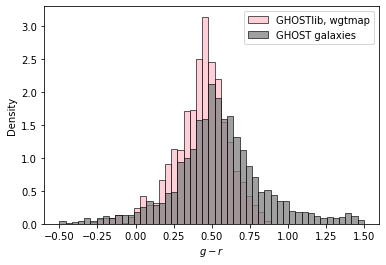

In [107]:
bins = np.linspace(-.5, 1.5)
sns.histplot(gr_hw, stat='density', bins=bins, label='GHOSTlib, wgtmap', color='pink')
sns.histplot(g_gr, stat='density', bins=bins, color='grey', label='GHOST galaxies')
plt.xlabel(r"$g-r$")
plt.legend()

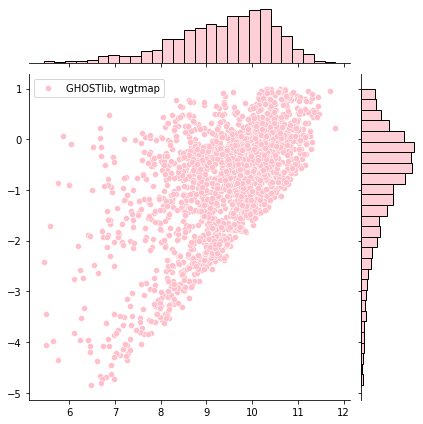

In [108]:
bins = np.linspace(5,12)

sns.jointplot(x=logmass_hw.to_numpy(), y=sfr_hw.to_numpy(), label='GHOSTlib, wgtmap', color='pink')
# sns.histplot(gR, stat='density', bins=bins, color='grey', label='GHOST galaxies')
# plt.xlabel(r"$log10(M_*)$")


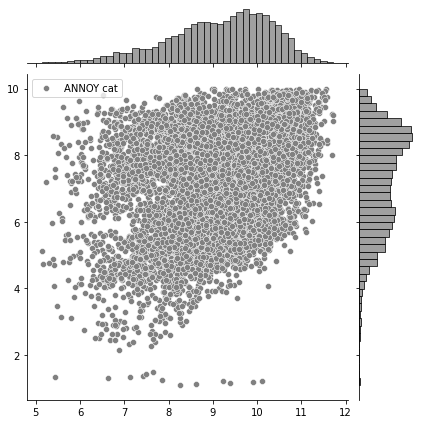

In [109]:
sns.jointplot(x=a_logmass.to_numpy(), y=a_sfr.to_numpy(),  label='ANNOY cat', color='gray')


In [105]:
len(a_logmass)

2008881